In [1]:
# Import libraries
import sys

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders
from src.utils import get_spacing, get_iso_center

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr
from diffdrr.data import read

from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh
import pyvista

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# Get transforms
transform = get_transforms(contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(
    root_dir="../data",
    collection="HCC-TACE-Seg",
    transform=transform,
    download_len=5,
    val_frac=0.2,
)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Get datalists
train_dl = train_ds.datalist
val_dl = val_ds.datalist

# Check length of datasets, dataloaders and datalists
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))
print(len(train_dl), len(val_dl))

2024-04-26 09:52:41,287 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip.
2024-04-26 09:52:41,287 - INFO - File exists: ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip, skipped downloading.
2024-04-26 09:52:41,287 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\raw\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.
2024-04-26 09:52:41,803 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip.
2024-04-26 09:52:41,803 - INFO - File exists: ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip, skipped downloading.
2024-04-26 09:52:41,803 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\HCC_017\300\image.
2024-04-26 09:52:42,103 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.208

In [3]:
print(train_dl)

[{'image': '..\\data\\HCC-TACE-Seg\\HCC_017\\300\\image', 'seg': '..\\data\\HCC-TACE-Seg\\HCC_017\\300\\seg'}, {'image': '..\\data\\HCC-TACE-Seg\\HCC_051\\300\\image', 'seg': '..\\data\\HCC-TACE-Seg\\HCC_051\\300\\seg'}, {'image': '..\\data\\HCC-TACE-Seg\\HCC_077\\300\\image', 'seg': '..\\data\\HCC-TACE-Seg\\HCC_077\\300\\seg'}, {'image': '..\\data\\HCC-TACE-Seg\\HCC_081\\300\\image', 'seg': '..\\data\\HCC-TACE-Seg\\HCC_081\\300\\seg'}]


In [4]:
# labels = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]

# structures = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]
# labels = subject.structures.query(f"group in {structures}")["id"].tolist()

# Read in CT volume and label map
subject = read(train_dl[0]["image"], train_dl[0]["seg"], orientation="AP", bone_attenuation_multiplier=5)

In [5]:
# Create a DRR object
drr = DRR(
    subject,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    width=200,  # Width of the DRR
    delx=2.0,  # Pixel spacing (in mm)
    dely=2.0,  # Pixel spacing (in mm)
    x0=0,  # # Principal point X-offset
    y0=0,  # Principal point Y-offset
    p_subsample = None,  # Proportion of pixels to randomly subsample
    reshape = True,  # Return DRR with shape (b, 1, h, w)
    reverse_x_axis = True,  # If True, obey radiologic convention (e.g., heart on right)
    patch_size = None,  # Render patches of the DRR in series
    renderer = "siddon",  # Rendering backend, either "siddon" or "trilinear"
).to(device)

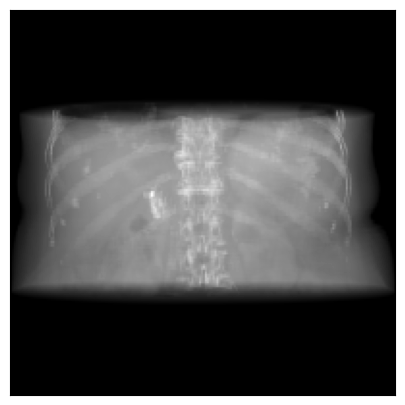

In [7]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY", mask_to_channels = False)
plot_drr(img, ticks=False)
plt.show()

In [8]:
import nibabel as nib
import numpy as np

# Load the image
mask = nib.load("../DiffDRR/notebooks/api/data/mask.nii.gz")

# Get the image data as a numpy array
mask_data = mask.get_fdata()

# Print the numpy array
print(mask_data)

unique_values = np.unique(mask_data)
print(len(unique_values))

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
90


In [9]:
img.shape

torch.Size([1, 1, 200, 200])